In [1]:
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [9]:
api = wandb.Api()
entity, project = "s232958-danmarks-tekniske-universitet-dtu", "CLIP_retrain_w_PPint0.1"
runs_weighting = api.runs(f"{entity}/{project}")

# Use the exact casing from your W&B logs
Keys = [
    "PPint Train-loss", "PPint Test-Loss", "Meta Val-loss", 
    "PPint non-dimer AUROC", "PPint non-dimer AUPR", "PPint Accuracy",
    "Meta Val-AUROC", "Meta Val-AUPR", "Meta Accuracy"
]

all_runs_list = [] 

print(f"Fetching history for {len(runs_weighting)} runs...")

for run in tqdm(runs_weighting):
    strategy = run.name.split("_")[0]
    
    # scan_history is the most reliable for capturing "Before training" + all epochs
    history = run.scan_history()

    # Initialize a dictionary of lists for this specific run
    run_data = {k: [] for k in Keys}
    run_data["epoch"] = []
    run_data["strategy"] = strategy

    for row in history:
        if any(k in row for k in Keys):
            for k in Keys:
                val = row.get(k)
                if val is not None:
                    run_data[k].append(val)
                elif val is None:
                    run_data[k].append(0)
            
            run_data["epoch"].append(row.get("_step", 0))

    temp_df = pd.DataFrame({k: run_data[k] for k in Keys + ["epoch"]})
    temp_df["strategy"] = strategy
    all_runs_list.append(temp_df)

# Combine all run DataFrames into one large master DataFrame
Df = pd.concat(all_runs_list, ignore_index=True)

# Verify Step 0
print(f"Total rows fetched: {len(Df)}")
print("First 5 steps for the first run:")
print(Df.head())

Fetching history for 14 runs...


100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.56it/s]

Total rows fetched: 174
First 5 steps for the first run:
   PPint Train-loss  PPint Test-Loss  Meta Val-loss  PPint non-dimer AUROC  \
0          0.000000         6.290573      10.385990               0.647177   
1          0.503681         0.265750       0.464291               0.751780   
2          0.258187         0.231884       0.517042               0.753886   
3          0.209616         0.204161       0.416406               0.800339   
4          0.187656         0.199750       0.405554               0.792234   

   PPint non-dimer AUPR  PPint Accuracy  Meta Val-AUROC  Meta Val-AUPR  \
0              0.386050        0.856566        0.513365       0.127711   
1              0.446238        0.903030        0.472768       0.102428   
2              0.457751        0.909091        0.498128       0.118387   
3              0.499039        0.913131        0.517932       0.134969   
4              0.487485        0.919192        0.497801       0.111543   

   Meta Accuracy  epoch     s

In [10]:
Df = Df.rename(columns={
    "PPint Train-loss" : "train_loss", 
    "PPint Test-Loss" : "test_loss", 
    "Meta Val-loss" : "val_loss", 
    "PPint non-dimer AUROC" : "non_dimer_AUROC", 
    "PPint non-dimer AUPR" : "non_dimer_AUPR", 
    "PPint Accuracy" : "non_dimer_accuracy",
    "Meta Val-AUROC": "meta_AUROC", 
    "Meta Val-AUPR" : "meta_AUPR", 
    "Meta Accuracy" : "meta_accuracy"
})
Df

,train_loss,test_loss,val_loss,non_dimer_AUROC,non_dimer_AUPR,non_dimer_accuracy,meta_AUROC,meta_AUPR,meta_accuracy,epoch,strategy
0,0.000000,6.290573,10.385990,0.647177,0.386050,0.856566,0.513365,0.127711,0.110702,0,ESM2&dilCNN
1,0.503681,0.265750,0.464291,0.751780,0.446238,0.903030,0.472768,0.102428,0.870328,1,ESM2&dilCNN
2,0.258187,0.231884,0.517042,0.753886,0.457751,0.909091,0.498128,0.118387,0.830974,2,ESM2&dilCNN
3,0.209616,0.204161,0.416406,0.800339,0.499039,0.913131,0.517932,0.134969,0.883918,3,ESM2&dilCNN
4,0.187656,0.199750,0.405554,0.792234,0.487485,0.919192,0.497801,0.111543,0.887599,4,ESM2&dilCNN
...,...,...,...,...,...,...,...,...,...,...,...
169,0.000000,6.230972,10.444002,0.650571,0.372559,0.832000,0.509737,0.123881,0.110702,0,ESM2&ESMIF\scaler(sigmoid(0.5))\increaseLR\L1Loss
170,0.563896,0.239442,0.415339,0.726463,0.447522,0.868000,0.481336,0.104231,0.886750,1,ESM2&ESMIF\scaler(sigmoid(0.5))\increaseLR\L1Loss
171,0.254319,0.244203,0.422561,0.769037,0.467160,0.866000,0.484904,0.113529,0.883069,2,ESM2&ESMIF\scaler(sigmoid(0.5))\increaseLR\L1Loss
172,0.201156,0.237103,0.407085,0.810900,0.507075,0.856000,0.482511,0.106218,0.888448,3,ESM2&ESMIF\scaler(sigmoid(0.5))\increaseLR\L1Loss


In [11]:
Df.strategy.unique()

array(['ESM2&dilCNN', 'ESM2&ViT', 'ESM2', 'ESMC', 'ESM2&simpCNN', 'ESMIF',
       'ESM2&ESMIF', 'ESM2&ViT\\scaler(tanh(1.0))',
       'ESM2&ViT\\scaler(sigmoid(0.0))\\increaseLR',
       'ESM2&simpCNN\\scaler(sigmoid(0.0))\\increaseLR',
       'ESM2&simpCNN\\scaler(sigmoid(0.0))\\increaseLR\\L1Loss',
       'ESM2&ViT\\scaler(sigmoid(0.0))\\increaseLR\\L1Loss',
       'ESM2&ESMIF\\scaler(sigmoid(0.0))\\increaseLR',
       'ESM2&ESMIF\\scaler(sigmoid(0.5))\\increaseLR\\L1Loss'],
      dtype=object)

### ESM-2-ViT

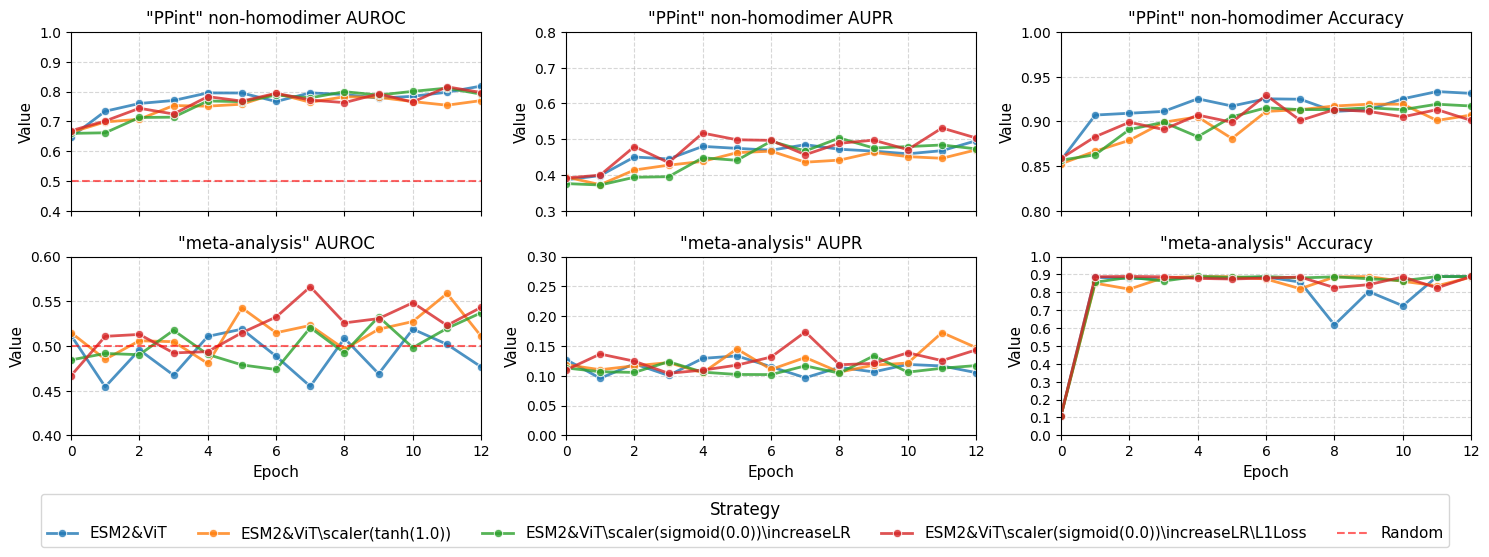

In [6]:
# 1. Define the metrics and their layout
# Top row: PPint (Train/Test) | Bottom row: Meta (Validation)
metrics = [
    "non_dimer_AUROC", "non_dimer_AUPR", "non_dimer_accuracy",
    "meta_AUROC", "meta_AUPR", "meta_accuracy"
]

titles = [
    '"PPint" non-homodimer AUROC', '"PPint" non-homodimer AUPR', '"PPint" non-homodimer Accuracy',
    '"meta-analysis" AUROC', '"meta-analysis" AUPR', '"meta-analysis" Accuracy'
]

ticks= [0.1, 0.05, 0.05, 0.05, 0.05, 0.1]

# 2. Set up the figure (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharex=True)
flat_axes = axes.flatten()

# 3. Plot each metric
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = flat_axes[i]
    
    # lineplot handles CV splits automatically (mean + confidence interval)
    sns.lineplot(
        data=Df[Df.strategy.str.startswith("ESM2&ViT")], 
        x="epoch", 
        y=metric, 
        hue="strategy", 
        ax=ax, 
        marker='o', 
        linewidth=2,
        alpha=0.8
    )
    
    ax.set_title(title, fontsize=12)
    ax.set_ylabel("Value", fontsize=11)
    ax.set_xlabel("Epoch" if i >= 3 else "", fontsize = 11)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(0, 12)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ticks[i]))
    
    # Add random baseline (0.5) for AUROC plots
    if metric == "non_dimer_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 1.0)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    elif metric == "non_dimer_AUPR":
        ax.set_ylim(0.3, 0.8)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    elif metric == "non_dimer_accuracy":
        ax.set_ylim(0.8, 1.0)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 0.6)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_AUPR":
        ax.set_ylim(0.0, 0.30)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_accuracy":
        ax.set_ylim(0.0, 1.0)

    # Remove individual legends to avoid clutter
    if ax.get_legend():
        ax.get_legend().remove()

# 4. Add a single global legend
handles, labels = flat_axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    title="Strategy", 
    loc='lower center', 
    ncol=len(labels), 
    bbox_to_anchor=(0.5, -0.12),
    fontsize=11,
    title_fontsize = 12
)

# plt.suptitle("Comparative Performance Models with Structural Information Track", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

### ESM-2-CNN

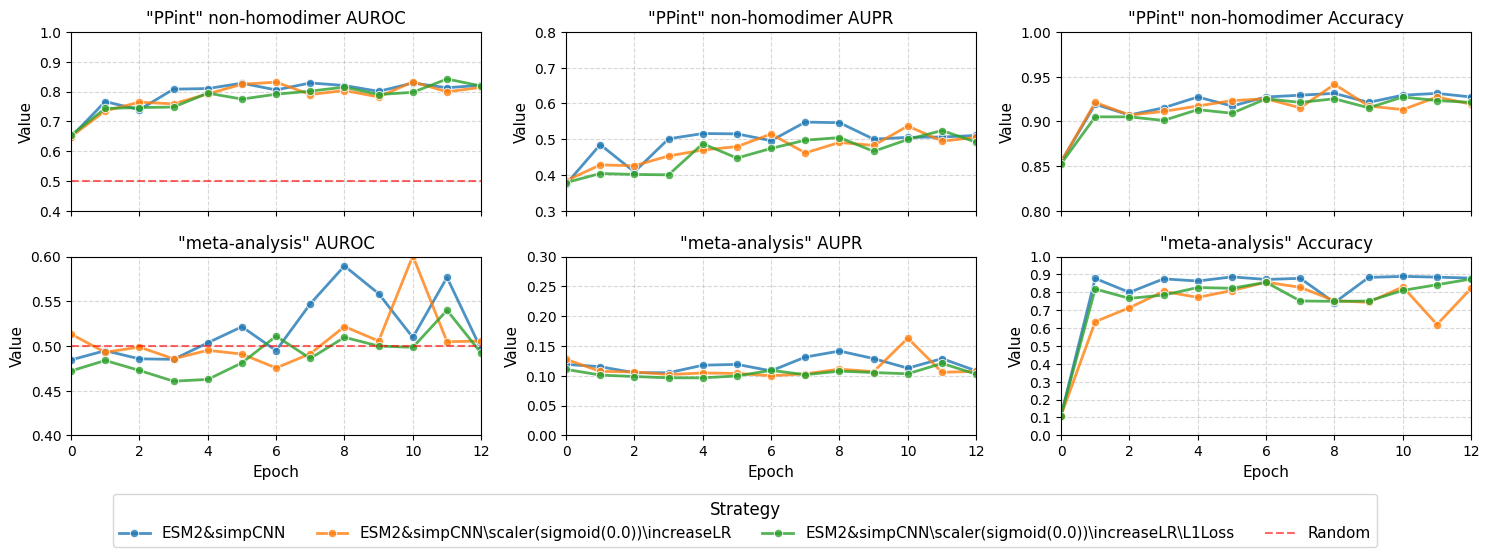

In [7]:
# 1. Define the metrics and their layout
# Top row: PPint (Train/Test) | Bottom row: Meta (Validation)
metrics = [
    "non_dimer_AUROC", "non_dimer_AUPR", "non_dimer_accuracy",
    "meta_AUROC", "meta_AUPR", "meta_accuracy"
]

titles = [
    '"PPint" non-homodimer AUROC', '"PPint" non-homodimer AUPR', '"PPint" non-homodimer Accuracy',
    '"meta-analysis" AUROC', '"meta-analysis" AUPR', '"meta-analysis" Accuracy'
]

ticks= [0.1, 0.05, 0.05, 0.05, 0.05, 0.1]

# 2. Set up the figure (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharex=True)
flat_axes = axes.flatten()

# 3. Plot each metric
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = flat_axes[i]
    
    # lineplot handles CV splits automatically (mean + confidence interval)
    sns.lineplot(
        data=Df[Df.strategy.str.startswith("ESM2&simpCNN")], 
        x="epoch", 
        y=metric, 
        hue="strategy", 
        ax=ax, 
        marker='o', 
        linewidth=2,
        alpha=0.8
    )
    
    ax.set_title(title, fontsize=12)
    ax.set_ylabel("Value", fontsize=11)
    ax.set_xlabel("Epoch" if i >= 3 else "", fontsize = 11)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(0, 12)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ticks[i]))
    
    # Add random baseline (0.5) for AUROC plots
    if metric == "non_dimer_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 1.0)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    elif metric == "non_dimer_AUPR":
        ax.set_ylim(0.3, 0.8)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    elif metric == "non_dimer_accuracy":
        ax.set_ylim(0.8, 1.0)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 0.6)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_AUPR":
        ax.set_ylim(0.0, 0.30)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_accuracy":
        ax.set_ylim(0.0, 1.0)

    # Remove individual legends to avoid clutter
    if ax.get_legend():
        ax.get_legend().remove()

# 4. Add a single global legend
handles, labels = flat_axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    title="Strategy", 
    loc='lower center', 
    ncol=len(labels), 
    bbox_to_anchor=(0.5, -0.12),
    fontsize=11,
    title_fontsize = 12
)

# plt.suptitle("Comparative Performance Models with Structural Information Track", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

### ESM-2-ESM-IF

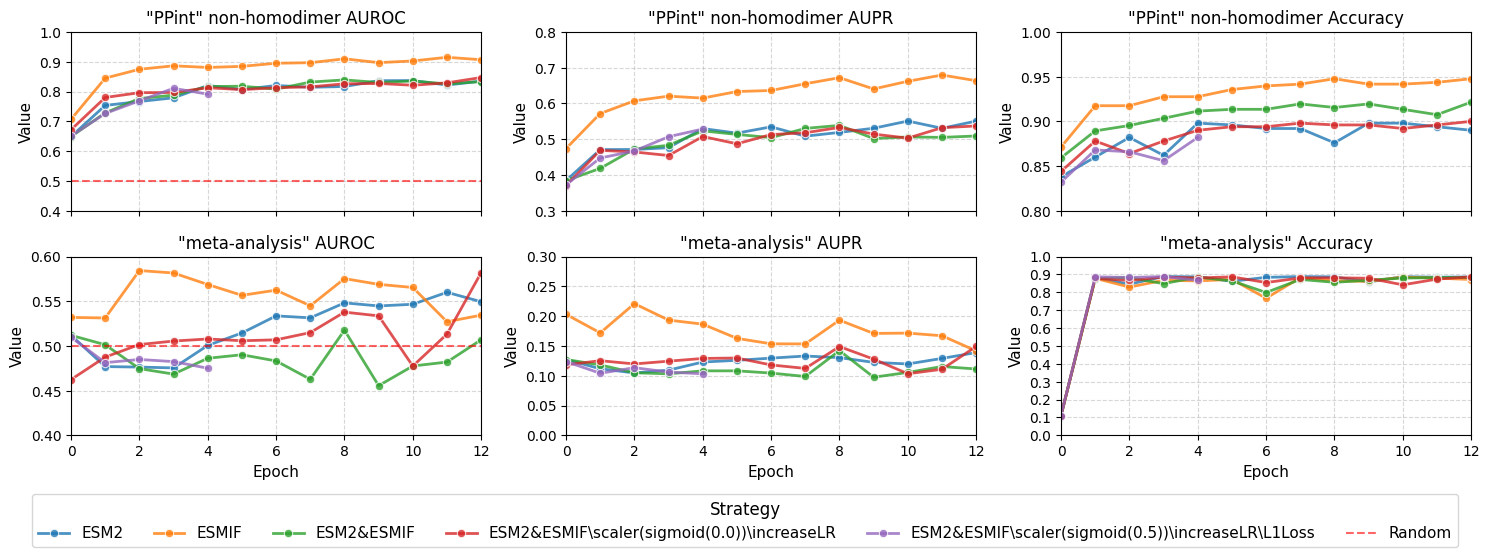

In [15]:
# 1. Define the metrics and their layout
# Top row: PPint (Train/Test) | Bottom row: Meta (Validation)
metrics = [
    "non_dimer_AUROC", "non_dimer_AUPR", "non_dimer_accuracy",
    "meta_AUROC", "meta_AUPR", "meta_accuracy"
]

titles = [
    '"PPint" non-homodimer AUROC', '"PPint" non-homodimer AUPR', '"PPint" non-homodimer Accuracy',
    '"meta-analysis" AUROC', '"meta-analysis" AUPR', '"meta-analysis" Accuracy'
]

ticks= [0.1, 0.05, 0.05, 0.05, 0.05, 0.1]

# 2. Set up the figure (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharex=True)
flat_axes = axes.flatten()

# 3. Plot each metric
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = flat_axes[i]
    
    # lineplot handles CV splits automatically (mean + confidence interval)
    sns.lineplot(
        data=Df[Df.strategy.str.startswith("ESM2&ESMIF", na=False) | (Df.strategy.isin(["ESM2", "ESMIF"]))], 
        x="epoch", 
        y=metric, 
        hue="strategy", 
        ax=ax, 
        marker='o', 
        linewidth=2,
        alpha=0.8
    )
    
    ax.set_title(title, fontsize=12)
    ax.set_ylabel("Value", fontsize=11)
    ax.set_xlabel("Epoch" if i >= 3 else "", fontsize = 11)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(0, 12)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ticks[i]))
    
    # Add random baseline (0.5) for AUROC plots
    if metric == "non_dimer_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 1.0)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    elif metric == "non_dimer_AUPR":
        ax.set_ylim(0.3, 0.8)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    elif metric == "non_dimer_accuracy":
        ax.set_ylim(0.8, 1.0)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 0.6)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_AUPR":
        ax.set_ylim(0.0, 0.30)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_accuracy":
        ax.set_ylim(0.0, 1.0)

    # Remove individual legends to avoid clutter
    if ax.get_legend():
        ax.get_legend().remove()

# 4. Add a single global legend
handles, labels = flat_axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    title="Strategy", 
    loc='lower center', 
    ncol=len(labels), 
    bbox_to_anchor=(0.5, -0.12),
    fontsize=11,
    title_fontsize = 12
)

# plt.suptitle("Comparative Performance Models with Structural Information Track", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

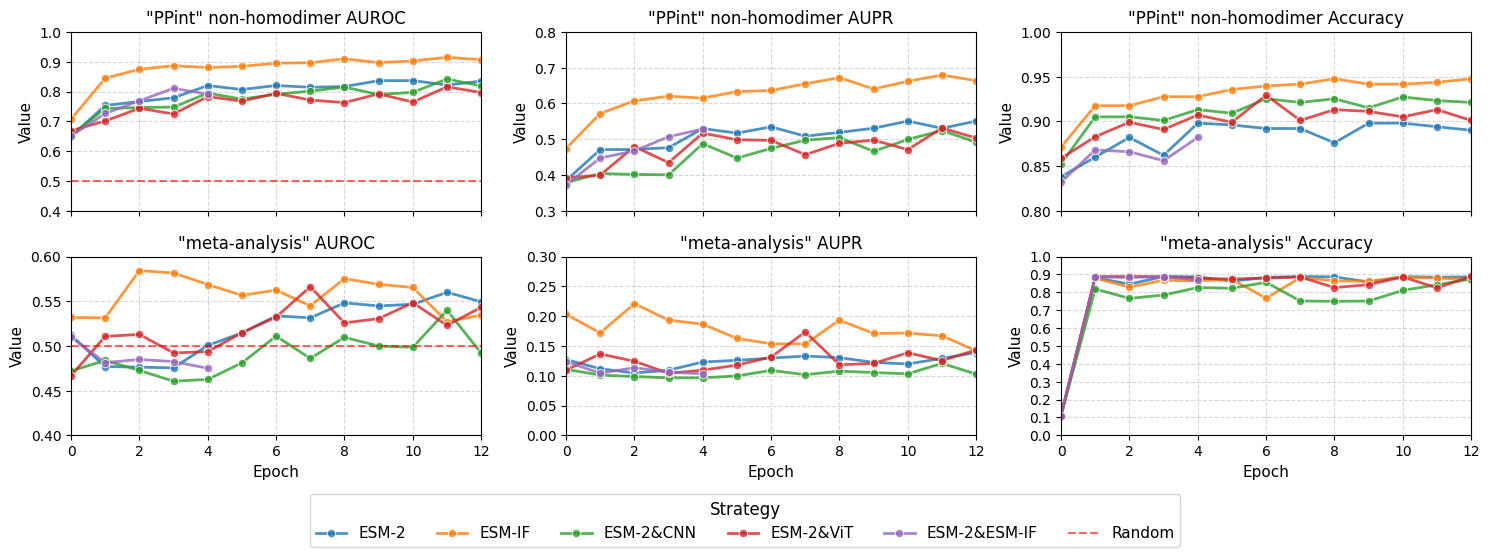

In [23]:
# 1. Define the metrics and their layout
# Top row: PPint (Train/Test) | Bottom row: Meta (Validation)
metrics = [
    "non_dimer_AUROC", "non_dimer_AUPR", "non_dimer_accuracy",
    "meta_AUROC", "meta_AUPR", "meta_accuracy"
]

titles = [
    '"PPint" non-homodimer AUROC', '"PPint" non-homodimer AUPR', '"PPint" non-homodimer Accuracy',
    '"meta-analysis" AUROC', '"meta-analysis" AUPR', '"meta-analysis" Accuracy'
]

ticks= [0.1, 0.05, 0.05, 0.05, 0.05, 0.1]

# 2. Set up the figure (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharex=True)
flat_axes = axes.flatten()

# 3. Plot each metric
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = flat_axes[i]
    
    # lineplot handles CV splits automatically (mean + confidence interval)
    sns.lineplot(
        data=Df[Df.strategy.isin(["ESM2", "ESMIF", "ESM2&simpCNN\\scaler(sigmoid(0.0))\\increaseLR\\L1Loss", "ESM2&ViT\\scaler(sigmoid(0.0))\\increaseLR\\L1Loss", "ESM2&ESMIF\\scaler(sigmoid(0.5))\\increaseLR\\L1Loss"])], 
        x="epoch", 
        y=metric, 
        hue="strategy", 
        ax=ax, 
        marker='o', 
        linewidth=2,
        alpha=0.8
    )
    
    ax.set_title(title, fontsize=12)
    ax.set_ylabel("Value", fontsize=11)
    ax.set_xlabel("Epoch" if i >= 3 else "", fontsize = 11)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(0, 12)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ticks[i]))
    
    # Add random baseline (0.5) for AUROC plots
    if metric == "non_dimer_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 1.0)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    elif metric == "non_dimer_AUPR":
        ax.set_ylim(0.3, 0.8)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    elif metric == "non_dimer_accuracy":
        ax.set_ylim(0.8, 1.0)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 0.6)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_AUPR":
        ax.set_ylim(0.0, 0.30)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    elif metric == "meta_accuracy":
        ax.set_ylim(0.0, 1.0)

    # Remove individual legends to avoid clutter
    if ax.get_legend():
        ax.get_legend().remove()

# 4. Add a single global legend
handles, labels = flat_axes[0].get_legend_handles_labels()
labels= ["ESM-2", "ESM-IF", "ESM-2&CNN", "ESM-2&ViT", "ESM-2&ESM-IF", "Random"]
fig.legend(
    handles, labels, 
    title="Strategy", 
    loc='lower center', 
    ncol=len(labels), 
    bbox_to_anchor=(0.5, -0.12),
    fontsize=11,
    title_fontsize = 12
)

# plt.suptitle("Comparative Performance Models with Structural Information Track", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

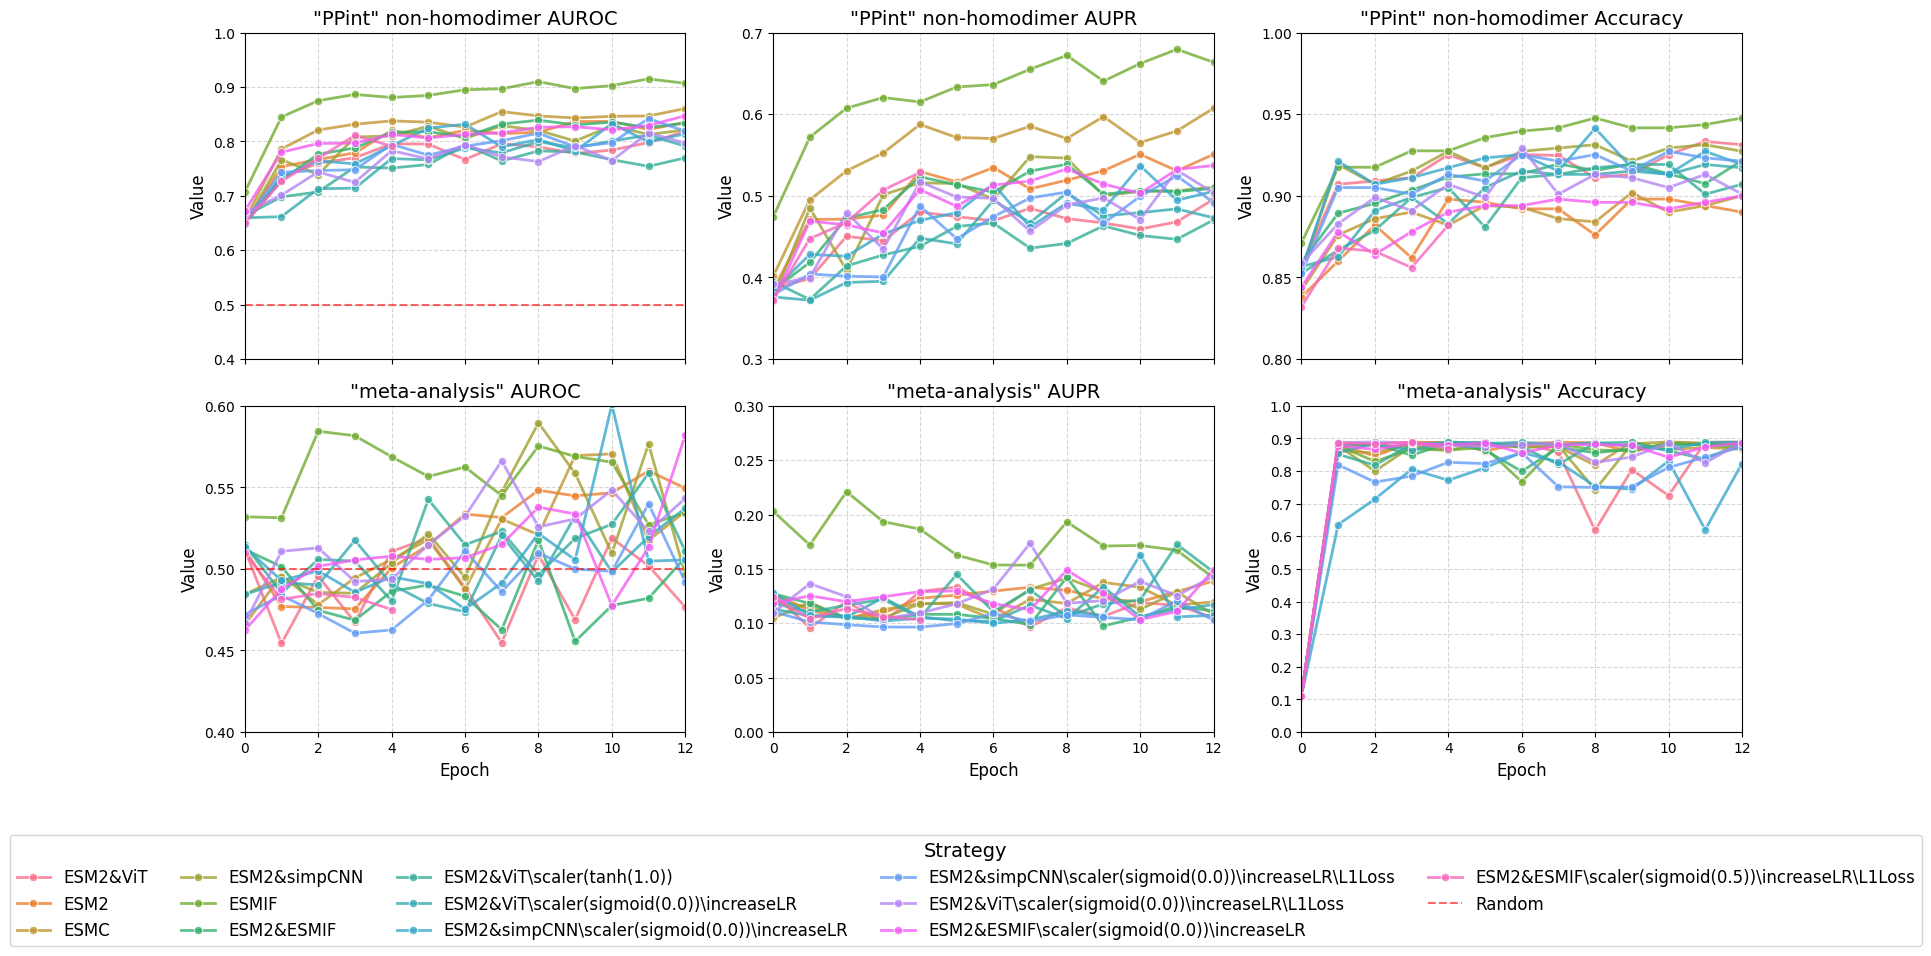

In [22]:
# 1. Define the metrics and their layout
# Top row: PPint (Train/Test) | Bottom row: Meta (Validation)
metrics = [
    "non_dimer_AUROC", "non_dimer_AUPR", "non_dimer_accuracy",
    "meta_AUROC", "meta_AUPR", "meta_accuracy"
]

titles = [
    '"PPint" non-homodimer AUROC', '"PPint" non-homodimer AUPR', '"PPint" non-homodimer Accuracy',
    '"meta-analysis" AUROC', '"meta-analysis" AUPR', '"meta-analysis" Accuracy'
]
ticks= [0.1, 0.1, 0.05, 0.05, 0.05, 0.1]

# 2. Set up the figure (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True)
flat_axes = axes.flatten()

# 3. Plot each metric
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = flat_axes[i]
    
    # lineplot handles CV splits automatically (mean + confidence interval)
    sns.lineplot(
        data=Df[~Df.strategy.isin(["ESM2&dilCNN"])], 
        x="epoch", 
        y=metric, 
        hue="strategy", 
        ax=ax, 
        marker='o', 
        linewidth=2,
        alpha=0.8
    )
    
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Value", fontsize=12)
    ax.set_xlabel("Epoch" if i >= 3 else "", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_xlim(0, 12)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ticks[i]))
    
    # Add random baseline (0.5) for AUROC plots
    if metric == "non_dimer_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 1.0)
    elif metric == "non_dimer_AUPR":
        ax.set_ylim(0.3, 0.7)
    elif metric == "non_dimer_accuracy":
        ax.set_ylim(0.8, 1.0)
    elif metric == "meta_AUROC":
        ax.axhline(0.5, color='red', linestyle='--', alpha=0.6, label="Random")
        ax.set_ylim(0.4, 0.6)
    elif metric == "meta_AUPR":
        ax.set_ylim(0.0, 0.3)
    elif metric == "meta_accuracy":
        ax.set_ylim(0.0, 1.0)

    # Remove individual legends to avoid clutter
    if ax.get_legend():
        ax.get_legend().remove()

# 4. Add a single global legend
handles, labels = flat_axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    title="Strategy", 
    loc='lower center', 
    ncol=5, 
    bbox_to_anchor=(0.5, -0.2),
    fontsize=12,
    title_fontsize = 14
)

# plt.suptitle("Comparative Performance Models with Structural Information Track", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()